In [4]:
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import collections

Matplotlib is building the font cache; this may take a moment.


## Which vep tool should I use? 
First, I read in the missense mutation effect predictions from dbNSFP for chd and control data.

In [5]:
test_df = pd.read_table('chd.missense.scores.08_21_20.txt')
#test_df = pd.read_table('chd.missense.denovo.dbnsfp_output.110323.tsv')

In [6]:
chd_score_dict = {}

with open('chd.missense.scores.08_21_20.txt', 'r') as chd_scores_f:
    chd_scores_reader = csv.reader(chd_scores_f, delimiter = '\t')
    header = next(chd_scores_reader)
    print(header)
    
    for row in chd_scores_reader:
        chrom = row[0]
        pos = row[1]
        ref = row[2]
        alt = row[3]
        
        effects = []
        canon_index = row[10].split(';').index('YES')
        genename = row[8].split(';')[canon_index]

        effects.append(genename)
        effects.append(row[9].split(';')[canon_index]) # amino acid
        #print(genename)
        for i in range(11,39):
            #print(header[i])
            #print(row[i].split(';')[canon_index])
            #chd_score_dict[(chrom,pos,ref,alt)][header[i]] = row[i].split(';')[canon_index]

            if len(row[i].split(';')) == 1:
                if row[i] == '.':
                    score = None
                else:
                    score = float(row[i])
            else:
                #score = row[i].split(';')[canon_index]
                scores = row[i].split(';')
                # Only PROVEAN has lower scores meaning damaging
                if header[i] != 'PROVEAN_score':
                    max_score = float('-inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) > max_score: 
                                max_score = float(j)
                    if max_score == float('-inf'):
                        score = None
                    else:
                        score = max_score
                else:
                    min_score = float('inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) < min_score: 
                                min_score = float(j)
                    if min_score == float('inf'):
                        score = None
                    else:
                        score = min_score
                #if score == '.':
                #    print(header[i],row[i])
            effects.append(score)
        chd_score_dict[(chrom,pos,ref,alt)] = effects

['#chr', 'pos(1-based)', 'ref', 'alt', 'aaref', 'aaalt', 'hg19_chr', 'hg19_pos(1-based)', 'genename', 'HGVSp_ANNOVAR', 'VEP_canonical', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MVP_score', 'MVP_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']


In [7]:
control_score_hg19_dict = {}
control_score_hg38_dict = {}
mis_hg19_to_hg38_dict = {}

with open('control.missense.scores.08_21_20.txt', 'r') as control_scores_f:
    control_scores_reader = csv.reader(control_scores_f, delimiter = '\t')
    header = next(control_scores_reader)
    print(header)
    new_header = ['genename', 'effects', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']
    for row in control_scores_reader:
        chrom = row[6]
        pos = row[7]
        ref = row[2]
        alt = row[3]
        
        hg38_chrom = row[0]
        hg38_pos = row[1]
        
        effects = []
        canon_index = row[10].split(';').index('YES')
        genename = row[8].split(';')[canon_index]

        effects.append(genename)
        effects.append(row[9].split(';')[canon_index]) # amino acid

        for i in range(11,39):
            if len(row[i].split(';')) == 1:
                if row[i] == '.':
                    score = None
                else:
                    score = float(row[i])
            else:
                #score = row[i].split(';')[canon_index]
                scores = row[i].split(';')
                # Only PROVEAN has lower scores meaning damaging
                if header[i] != 'PROVEAN_score':
                    max_score = float('-inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) > max_score: 
                                max_score = float(j)
                    if max_score == float('-inf'):
                        score = None
                    else:
                        score = max_score
                else:
                    min_score = float('inf')
                    for j in scores:
                        if (j) != '.':
                            if float(j) < min_score: 
                                min_score = float(j)
                    if min_score == float('inf'):
                        score = None
                    else:
                        score = min_score

            effects.append(score)
        mis_hg19_to_hg38_dict[(chrom,pos,ref,alt)] = (hg38_chrom,hg38_pos,ref,alt)
        control_score_hg38_dict[(hg38_chrom,hg38_pos,ref,alt)] = effects
        control_score_hg19_dict[(chrom,pos,ref,alt)] = effects

['#chr', 'pos(1-based)', 'ref', 'alt', 'aaref', 'aaalt', 'hg19_chr', 'hg19_pos(1-based)', 'genename', 'HGVSp_ANNOVAR', 'VEP_canonical', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MVP_score', 'MVP_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']


In [8]:
with open('Human_CHD_genes.txt', 'r') as hum_chd_f:
    hum_chd_reader = csv.reader(hum_chd_f, delimiter = '\t')
    hum_chd_genes = []
    for row in hum_chd_reader:
        hum_chd_genes.append(row[0])
        
with open('Mouse_CHD_genes.txt', 'r') as mouse_chd_f:
    mouse_chd_reader = csv.reader(mouse_chd_f, delimiter = '\t')
    mouse_chd_genes = []
    for row in mouse_chd_reader:
        mouse_chd_genes.append(row[0])

For each variant that was found in the data, I fill in the scores. I count the recurrent mutations also.

In [9]:
# Aggregating CHD exome variant data
final_header = ['sample', 'chr', 'pos', 'ref', 'alt', 'genename', 'effects', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MVP_score', 'MVP_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']
hum_chd_scores = []
mouse_chd_scores = []
all_chd_scores = []
with open('seidman.hg38.final.bed', 'r') as seidman_f:
    seidman_var_reader = csv.reader(seidman_f, delimiter = '\t')
    for row in seidman_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(chd_score_dict[var])
            all_chd_scores.append(all_row)
            
            if chd_score_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(chd_score_dict[var])
                hum_chd_scores.append(hum_row)
            if chd_score_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(chd_score_dict[var])
                mouse_chd_scores.append(mouse_row)
                                
with open('s_chd.hg38.final.bed', 'r') as s_chd_f:
    s_chd_var_reader = csv.reader(s_chd_f, delimiter = '\t')
    for row in s_chd_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(chd_score_dict[var])
            all_chd_scores.append(all_row)            
            
            if chd_score_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(chd_score_dict[var])
                hum_chd_scores.append(hum_row)
            if chd_score_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(chd_score_dict[var])
                mouse_chd_scores.append(mouse_row)
                
with open('ns_chd.hg38.final.bed', 'r') as ns_chd_f:
    ns_chd_var_reader = csv.reader(ns_chd_f, delimiter = '\t')
    for row in ns_chd_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(chd_score_dict[var])
            all_chd_scores.append(all_row)
            
            if chd_score_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(chd_score_dict[var])
                hum_chd_scores.append(hum_row)
            if chd_score_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(chd_score_dict[var])
                mouse_chd_scores.append(mouse_row)
                
                
#print(len(final_header))
hum_chd_scores = pd.DataFrame(np.array(hum_chd_scores),columns=final_header)
mouse_chd_scores = pd.DataFrame(np.array(mouse_chd_scores),columns=final_header)
all_chd_scores = pd.DataFrame(np.array(all_chd_scores),columns=final_header)

In [10]:
final_header = ['sample', 'chr', 'pos', 'ref', 'alt', 'genename', 'effects', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_rankscore', 'MutationAssessor_score', 'MutationAssessor_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST4_score', 'VEST4_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'REVEL_score', 'REVEL_rankscore', 'MVP_score', 'MVP_rankscore', 'MPC_score', 'MPC_rankscore', 'PrimateAI_score', 'PrimateAI_rankscore', 'DEOGEN2_score', 'DEOGEN2_rankscore', 'CADD_raw', 'CADD_raw_rankscore']
hum_chd_control_scores = []
mouse_chd_control_scores = []
all_chd_control_scores = []

with open('autism.control.mutations.hg19.duplicate_filtered.txt', 'r') as control_f:
    control_var_reader = csv.reader(control_f, delimiter = '\t')
    for row in control_var_reader:
        #print(row)
        chrom = row[0]
        pos = row[1]
        ref = row[2]
        alt = row[3]
        sample = row[4]
        var = (chrom, pos, ref, alt)
        if (var) in control_score_hg19_dict:
            all_row = [sample]
            all_row.extend(list(var))
            all_row.extend(control_score_hg19_dict[var])
            all_chd_control_scores.append(all_row)
            
            
            if control_score_hg19_dict[var][0] in hum_chd_genes:
                hum_row = [sample]
                hum_row.extend(list(var))
                hum_row.extend(control_score_hg19_dict[var])
                hum_chd_control_scores.append(hum_row)
            if control_score_hg19_dict[var][0] in mouse_chd_genes:
                mouse_row = [sample]
                mouse_row.extend(list(var))
                mouse_row.extend(control_score_hg19_dict[var])
                mouse_chd_control_scores.append(mouse_row)
                
                
#print(len(final_header))
hum_chd_control_scores = pd.DataFrame(np.array(hum_chd_control_scores),columns=final_header)
mouse_chd_control_scores = pd.DataFrame(np.array(mouse_chd_control_scores),columns=final_header)
all_chd_control_scores = pd.DataFrame(np.array(all_chd_control_scores),columns=final_header)

In order to plot the score distribution, I convert the list of scores for each method (both raw score and rank score) as numpy arrays.

In [11]:
primateAI_chd = np.array(hum_chd_scores['PrimateAI_rankscore'], dtype=float)
primateAI_control = np.array(hum_chd_control_scores['PrimateAI_rankscore'], dtype=float)
primateAI_chd = primateAI_chd[np.isfinite(primateAI_chd)]
primateAI_control = primateAI_control[np.isfinite(primateAI_control)]

MPC_chd = np.array(hum_chd_scores['MPC_rankscore'], dtype=float)
MPC_control = np.array(hum_chd_control_scores['MPC_rankscore'], dtype=float)
MPC_chd = MPC_chd[np.isfinite(MPC_chd)]
MPC_control = MPC_control[np.isfinite(MPC_control)]

PROVEAN_chd = np.array(hum_chd_scores['PROVEAN_converted_rankscore'], dtype=float)
PROVEAN_control = np.array(hum_chd_control_scores['PROVEAN_converted_rankscore'], dtype=float)
PROVEAN_chd = PROVEAN_chd[np.isfinite(PROVEAN_chd)]
PROVEAN_control = PROVEAN_control[np.isfinite(PROVEAN_control)]

MVP_chd = np.array(hum_chd_scores['MVP_rankscore'], dtype=float)
MVP_control = np.array(hum_chd_control_scores['MVP_rankscore'], dtype=float)
MVP_chd = MVP_chd[np.isfinite(MVP_chd)]
MVP_control = MVP_control[np.isfinite(MVP_control)]

VEST4_chd = np.array(hum_chd_scores['VEST4_rankscore'], dtype=float)
VEST4_control = np.array(hum_chd_control_scores['VEST4_rankscore'], dtype=float)
VEST4_chd = VEST4_chd[np.isfinite(VEST4_chd)]
VEST4_control = VEST4_control[np.isfinite(VEST4_control)]

MA_chd = np.array(hum_chd_scores['MutationAssessor_rankscore'], dtype=float)
MA_control = np.array(hum_chd_control_scores['MutationAssessor_rankscore'], dtype=float)
MA_chd = MA_chd[np.isfinite(MA_chd)]
MA_control = MA_control[np.isfinite(MA_control)]


MSVM_chd = np.array(hum_chd_scores['MetaSVM_rankscore'], dtype=float)
MSVM_control = np.array(hum_chd_control_scores['MetaSVM_rankscore'], dtype=float)
MSVM_chd = MSVM_chd[np.isfinite(MSVM_chd)]
MSVM_control = MSVM_control[np.isfinite(MSVM_control)]


REVEL_chd = np.array(hum_chd_scores['REVEL_rankscore'], dtype=float)
REVEL_control = np.array(hum_chd_control_scores['REVEL_rankscore'], dtype=float)
REVEL_chd = REVEL_chd[np.isfinite(REVEL_chd)]
REVEL_control = REVEL_control[np.isfinite(REVEL_control)]


PP2_chd = np.array(hum_chd_scores['Polyphen2_HDIV_rankscore'], dtype=float)
PP2_control = np.array(hum_chd_control_scores['Polyphen2_HDIV_rankscore'], dtype=float)
PP2_chd = PP2_chd[np.isfinite(PP2_chd)]
PP2_control = PP2_control[np.isfinite(PP2_control)]

CADD_chd = np.array(hum_chd_scores['CADD_raw_rankscore'], dtype=float)
CADD_control = np.array(hum_chd_control_scores['CADD_raw_rankscore'], dtype=float)
CADD_chd = CADD_chd[np.isfinite(CADD_chd)]
CADD_control = CADD_control[np.isfinite(CADD_control)]

In [9]:
print("primateAI", len(primateAI_chd))
print("primateAI", len(primateAI_control))
print("MVP", len(MVP_chd))
print("MVP", len(MVP_control))
print("MPC", len(MPC_chd))
print("MPC", len(MPC_control))
print("VEST4", len(VEST4_chd))
print("VEST4", len(VEST4_control))
print("REVEL", len(REVEL_chd))
print("REVEL", len(REVEL_control))
print("PROVEAN", len(PROVEAN_chd))
print("PROVEAN", len(PROVEAN_control))
print("MA", len(MA_chd))
print("MA", len(MA_control))
print("CADD", len(CADD_chd))
print("CADD", len(CADD_control))
print("PP2", len(PP2_chd))
print("PP2", len(PP2_control))
print("MSVM", len(MSVM_chd))
print("MSVM", len(MSVM_control))

primateAI 113
primateAI 26
MVP 113
MVP 26
MPC 110
MPC 24
VEST4 113
VEST4 26
REVEL 113
REVEL 26
PROVEAN 113
PROVEAN 26
MA 108
MA 24
CADD 113
CADD 26
PP2 109
PP2 24
MSVM 113
MSVM 26


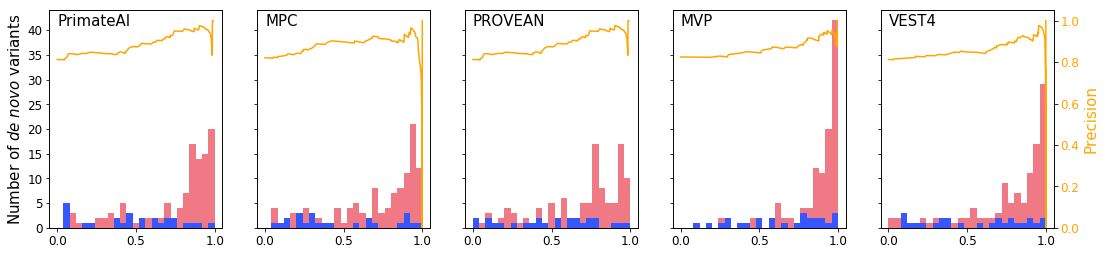

In [173]:
### Version two with true positive rate

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(18,4))#, tight_layout=True)

plt.rcParams.update({'font.size': 12})
plt.ylim((0,44))

axs[0].set_ylabel('Number of $\it{de}$ $\it{novo}$ variants', color = 'black', fontsize=15) 

# We can set the number of bins with the `bins` kwarg
axs[0].hist(primateAI_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[0].hist(primateAI_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[0].text(0, 41, 'PrimateAI', fontsize=15)

ax2 = axs[0].twinx()  
ax2.plot(np.insert(thresholds_3, 0,0), precision3 , color = 'orange')
#ax2.plot(np.insert(thresholds_3, 0,0), recall3 , color = 'red')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[1].hist(MPC_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[1].hist(MPC_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[1].text(0, 41, 'MPC', fontsize=15)
ax2 = axs[1].twinx()  
ax2.plot(np.insert(thresholds_10, 0,0), precision10 , color = 'orange')
#ax2.plot(np.insert(thresholds_10, 0,0), recall10 , color = 'red')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[2].hist(PROVEAN_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[2].hist(PROVEAN_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[2].text(0, 41, 'PROVEAN', fontsize=15)
#axs[2].set_xlabel('Score percentile', color = 'black', fontsize=14) 
ax2 = axs[2].twinx()  
ax2.plot(np.insert(thresholds_3, 0,0), precision3 , color = 'orange') 
plt.ylim((0,1.05))
plt.yticks([]) 


axs[3].hist(MVP_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[3].hist(MVP_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[3].text(0, 41, 'MVP', fontsize=15)
ax2 = axs[3].twinx()  
ax2.plot(np.insert(thresholds_4, 0,0), precision4, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[4].hist(VEST4_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[4].hist(VEST4_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[4].text(0, 41, 'VEST4', fontsize=15)
ax2 = axs[4].twinx()  
ax2.set_ylabel('Precision', color = 'orange', fontsize=15) 
ax2.plot(np.insert(thresholds_5, 0,0), precision5, color = 'orange')
ax2.tick_params(axis ='y', labelcolor = 'orange') 
plt.ylim((0,1.05))

plt.savefig('Fig1A.pdf')

plt.show()

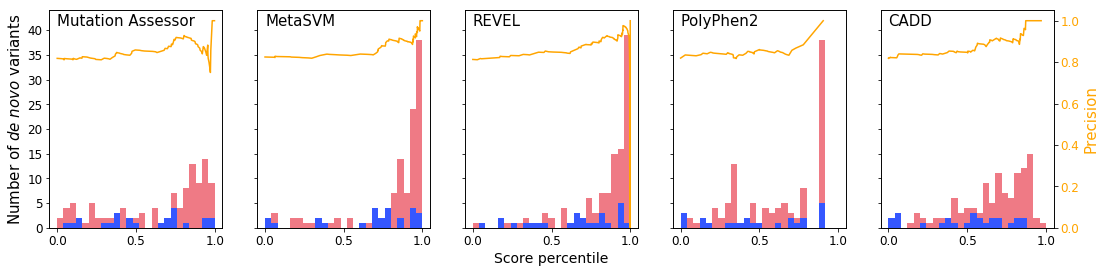

In [174]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(18,4))#, tight_layout=True)

plt.rcParams.update({'font.size': 12})
plt.ylim((0,44))

axs[0].set_ylabel('Number of $\it{de}$ $\it{novo}$ variants', color = 'black', fontsize=15) 

# We can set the number of bins with the `bins` kwarg
axs[0].hist(MA_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[0].hist(MA_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[0].text(0, 41, 'Mutation Assessor', fontsize=15)
ax2 = axs[0].twinx()  
ax2.plot(np.insert(thresholds_1, 0,0), precision, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[1].hist(MSVM_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[1].hist(MSVM_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[1].text(0, 41, 'MetaSVM', fontsize=15)
ax2 = axs[1].twinx()  
ax2.plot(np.insert(thresholds_6, 0,0), precision6, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[2].hist(REVEL_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[2].hist(REVEL_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[2].text(0, 41, 'REVEL', fontsize=15)
axs[2].set_xlabel('Score percentile', color = 'black', fontsize=14) 
ax2 = axs[2].twinx()  
ax2.plot(np.insert(thresholds_5, 0,0), precision5, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 

axs[3].hist(PP2_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[3].hist(PP2_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[3].text(0, 41, 'PolyPhen2', fontsize=15)
ax2 = axs[3].twinx()  
ax2.plot(np.insert(thresholds_8, 0,0), precision8, color = 'orange')
plt.ylim((0,1.05))
plt.yticks([]) 


axs[4].hist(CADD_chd, bins=np.array(range(0,26)) / 25, color = "#ef7a85")
axs[4].hist(CADD_control, bins=np.array(range(0,26)) / 25, color = "#3557ff")
axs[4].text(0, 41, 'CADD', fontsize=15)
ax2 = axs[4].twinx()  
ax2.set_ylabel('Precision', color = 'orange', fontsize=15) 
ax2.plot(np.insert(thresholds_9, 0,0), precision9, color = 'orange')
ax2.tick_params(axis ='y', labelcolor = 'orange') 
plt.ylim((0,1.05))

plt.savefig('Fig1B.pdf')

plt.show()

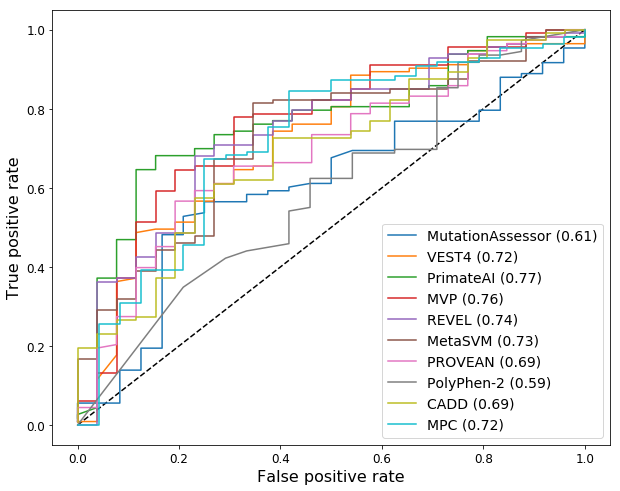

In [96]:
scores = np.append(MA_chd, MA_control)
y = np.append(np.repeat(1,len(MA_chd)), np.repeat(0,len(MA_control)))
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
precision, recall, thresholds_1 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(VEST4_chd, VEST4_control)
y = np.append(np.repeat(1,len(VEST4_chd)), np.repeat(0,len(VEST4_control)))
fpr2, tpr2, thresholds2 = roc_curve(y, scores, pos_label=1)
precision2, recall2, thresholds_2 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(primateAI_chd, primateAI_control)
y = np.append(np.repeat(1,len(primateAI_chd)), np.repeat(0,len(primateAI_control)))
fpr3, tpr3, thresholds3 = roc_curve(y, scores, pos_label=1)
precision3, recall3, thresholds_3 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(MVP_chd, MVP_control)
y = np.append(np.repeat(1,len(MVP_chd)), np.repeat(0,len(MVP_control)))
fpr4, tpr4, thresholds4 = roc_curve(y, scores, pos_label=1)
precision4, recall4, thresholds_4 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(REVEL_chd, REVEL_control)
y = np.append(np.repeat(1,len(REVEL_chd)), np.repeat(0,len(REVEL_control)))
fpr5, tpr5, thresholds5 = roc_curve(y, scores, pos_label=1)
precision5, recall5, thresholds_5 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(MSVM_chd, MSVM_control)
y = np.append(np.repeat(1,len(MSVM_chd)), np.repeat(0,len(MSVM_control)))
fpr6, tpr6, thresholds6 = roc_curve(y, scores, pos_label=1)
precision6, recall6, thresholds_6 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(PROVEAN_chd, PROVEAN_control)
y = np.append(np.repeat(1,len(PROVEAN_chd)), np.repeat(0,len(PROVEAN_control)))
fpr7, tpr7, thresholds7 = roc_curve(y, scores, pos_label=1)
precision7, recall7, thresholds_7 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(PP2_chd, PP2_control)
y = np.append(np.repeat(1,len(PP2_chd)), np.repeat(0,len(PP2_control)))
fpr8, tpr8, thresholds8 = roc_curve(y, scores, pos_label=1)
precision8, recall8, thresholds_8 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(CADD_chd, CADD_control)
y = np.append(np.repeat(1,len(CADD_chd)), np.repeat(0,len(CADD_control)))
fpr9, tpr9, thresholds9 = roc_curve(y, scores, pos_label=1)
precision9, recall9, thresholds_9 = precision_recall_curve(y, scores, pos_label=1)

scores = np.append(MPC_chd, MPC_control)
y = np.append(np.repeat(1,len(MPC_chd)), np.repeat(0,len(MPC_control)))
fpr10, tpr10, thresholds10 = roc_curve(y, scores, pos_label=1)
precision10, recall10, thresholds_10 = precision_recall_curve(y, scores, pos_label=1)


plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='MutationAssessor (%0.2f)' % auc(fpr,tpr))
plt.plot(fpr2, tpr2, label='VEST4 (%0.2f)' % auc(fpr2,tpr2))
plt.plot(fpr3, tpr3, label='PrimateAI (%0.2f)' % auc(fpr3,tpr3))
plt.plot(fpr4, tpr4, label='MVP (%0.2f)' % auc(fpr4,tpr4))
plt.plot(fpr5, tpr5, label='REVEL (%0.2f)' % auc(fpr5,tpr5))
plt.plot(fpr6, tpr6, label='MetaSVM (%0.2f)' % auc(fpr6,tpr6))
plt.plot(fpr7, tpr7, label='PROVEAN (%0.2f)' % auc(fpr7,tpr7))
plt.plot(fpr8, tpr8, label='PolyPhen-2 (%0.2f)' % auc(fpr8,tpr8))
plt.plot(fpr9, tpr9, label='CADD (%0.2f)' % auc(fpr9,tpr9))
plt.plot(fpr10, tpr10, label='MPC (%0.2f)' % auc(fpr10,tpr10))

plt.xlabel('False positive rate', color = 'black', fontsize=16) 
plt.ylabel('True positive rate', color = 'black', fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.savefig('FigS1A.pdf')

plt.show()

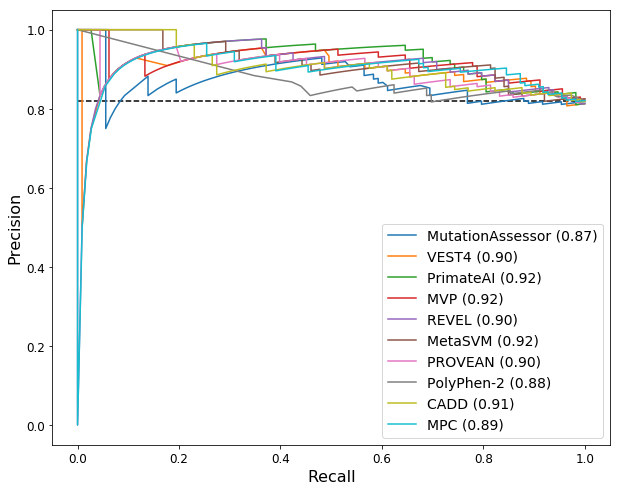

In [98]:
plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0.82, 0.82], 'k--')
plt.plot(recall, precision, label='MutationAssessor (%0.2f)' % auc(recall,precision))
plt.plot(recall2, precision2, label='VEST4 (%0.2f)' % auc(recall2,precision2))
plt.plot(recall3, precision3, label='PrimateAI (%0.2f)' % auc(recall3,precision3))
plt.plot(recall4, precision4, label='MVP (%0.2f)' % auc(recall4,precision4))
plt.plot(recall5, precision5, label='REVEL (%0.2f)' % auc(recall5,precision5))
plt.plot(recall6, precision6, label='MetaSVM (%0.2f)' % auc(recall6,precision6))
plt.plot(recall7, precision7, label='PROVEAN (%0.2f)' % auc(recall7,precision7))
plt.plot(recall8, precision8, label='PolyPhen-2 (%0.2f)' % auc(recall8,precision8))
plt.plot(recall9, precision9, label='CADD (%0.2f)' % auc(recall9,precision9))
plt.plot(recall10, precision10, label='MPC (%0.2f)' % auc(recall10,precision10))

plt.xlabel('Recall', color = 'black', fontsize=16) 
plt.ylabel('Precision', color = 'black', fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.savefig('FigS1B.pdf')

plt.show()

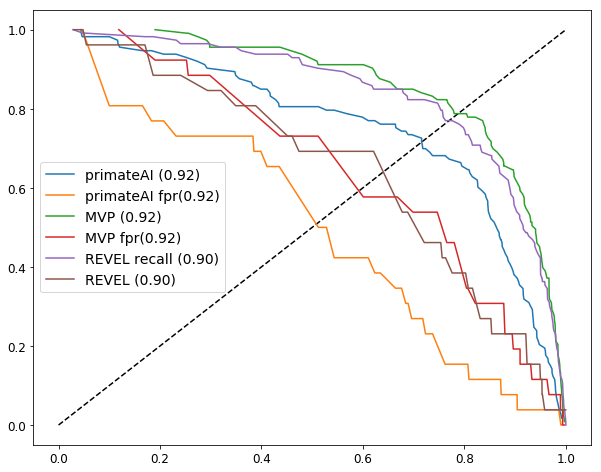

In [91]:
plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(recall, precision, label='MutationAssessor (%0.2f)' % auc(recall,precision))
#plt.plot(thresholds2, fpr2, label='VEST4 (%0.2f)' % auc(recall2,precision2))
#plt.plot(thresholds_3, precision3[:-1], label='primateAI (%0.2f)' % auc(recall3,precision3))
plt.plot(thresholds_3, recall3[:-1], label='primateAI (%0.2f)' % auc(recall3,precision3))
plt.plot(thresholds3, fpr3, label='primateAI fpr(%0.2f)' % auc(recall3,precision3))
#plt.plot(thresholds_4, precision4[:-1], label='MVP (%0.2f)' % auc(recall4,precision4))
plt.plot(thresholds_4, recall4[:-1], label='MVP (%0.2f)' % auc(recall4,precision4))
plt.plot(thresholds4, fpr4, label='MVP fpr(%0.2f)' % auc(recall4,precision4))
#plt.plot(thresholds_5, precision5[:-1], label='REVEL (%0.2f)' % auc(recall5,precision5))
plt.plot(thresholds_5, recall5[:-1], label='REVEL recall (%0.2f)' % auc(recall5,precision5))
plt.plot(thresholds5[1:], fpr5[1:], label='REVEL (%0.2f)' % auc(recall5,precision5))
#plt.plot(thresholds5, tpr5, label='REVEL tpr(%0.2f)' % auc(recall5,precision5))
#plt.plot(thresholds_6, precision6[:-1], label='metaSVM (%0.2f)' % auc(recall6,precision6))
#plt.plot(recall7, precision7, label='PROVEAN (%0.2f)' % auc(recall7,precision7))
#plt.plot(recall8, precision8, label='PolyPhen-2 (%0.2f)' % auc(recall8,precision8))
#plt.plot(recall9, precision9, label='CADD (%0.2f)' % auc(recall9,precision9))
#plt.plot(thresholds_10, precision10[:-1], label='MPC (%0.2f)' % auc(recall10,precision10))
#plt.plot(thresholds_10, recall10[:-1], label='MPC recall (%0.2f)' % auc(recall10,precision10))
#plt.plot(thresholds10, fpr10, label='MPC (%0.2f)' % auc(recall10,precision10))

plt.legend(loc='best', fontsize=14)

plt.show()

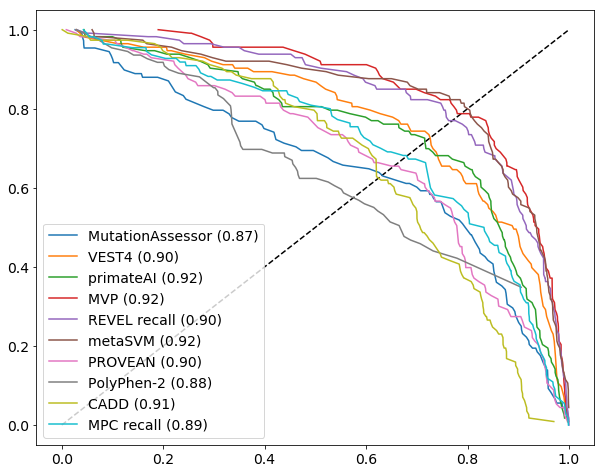

In [821]:
plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_1, recall[:-1], label='MutationAssessor (%0.2f)' % auc(recall,precision))
plt.plot(thresholds_2, recall2[:-1], label='VEST4 (%0.2f)' % auc(recall2,precision2))
#plt.plot(thresholds_3, precision3[:-1], label='primateAI (%0.2f)' % auc(recall3,precision3))
plt.plot(thresholds_3, recall3[:-1], label='primateAI (%0.2f)' % auc(recall3,precision3))
#plt.plot(thresholds3, fpr3, label='primateAI fpr(%0.2f)' % auc(recall3,precision3))
#plt.plot(thresholds_4, precision4[:-1], label='MVP (%0.2f)' % auc(recall4,precision4))
plt.plot(thresholds_4, recall4[:-1], label='MVP (%0.2f)' % auc(recall4,precision4))
#plt.plot(thresholds4, fpr4, label='MVP fpr(%0.2f)' % auc(recall4,precision4))
#plt.plot(thresholds_5, precision5[:-1], label='REVEL (%0.2f)' % auc(recall5,precision5))
plt.plot(thresholds_5, recall5[:-1], label='REVEL (%0.2f)' % auc(recall5,precision5))
#plt.plot(thresholds5[1:], fpr5[1:], label='REVEL (%0.2f)' % auc(recall5,precision5))
#plt.plot(thresholds5, tpr5, label='REVEL tpr(%0.2f)' % auc(recall5,precision5))
plt.plot(thresholds_6, recall6[:-1], label='metaSVM (%0.2f)' % auc(recall6,precision6))
plt.plot(thresholds_7, recall7[:-1], label='PROVEAN (%0.2f)' % auc(recall7,precision7))
plt.plot(thresholds_8, recall8[:-1], label='PolyPhen-2 (%0.2f)' % auc(recall8,precision8))
plt.plot(thresholds_9, recall9[:-1], label='CADD (%0.2f)' % auc(recall9,precision9))
#plt.plot(thresholds_10, precision10[:-1], label='MPC (%0.2f)' % auc(recall10,precision10))
plt.plot(thresholds_10, recall10[:-1], label='MPC recall (%0.2f)' % auc(recall10,precision10))
#plt.plot(thresholds10, fpr10, label='MPC (%0.2f)' % auc(recall10,precision10))

plt.legend(loc='best')

plt.show()

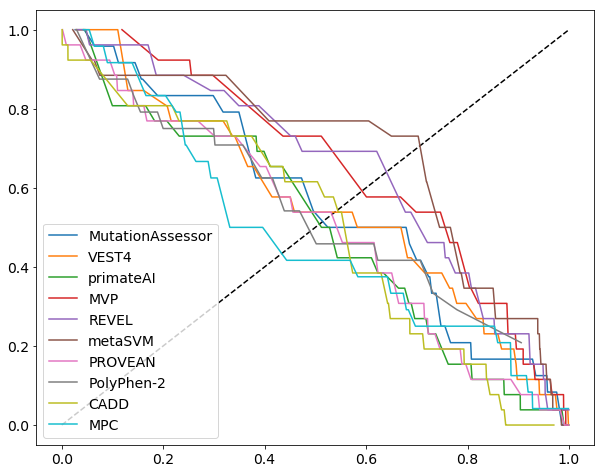

In [824]:
plt.figure(1, figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds, fpr, label='MutationAssessor')
plt.plot(thresholds2, fpr2, label='VEST4')
#plt.plot(thresholds_3, precision3[:-1], label='primateAI (%0.2f)' % auc(recall3,precision3))
#plt.plot(thresholds_3, recall3[:-1], label='primateAI (%0.2f)' % auc(recall3,precision3))
plt.plot(thresholds3, fpr3, label='primateAI')
#plt.plot(thresholds_4, precision4[:-1], label='MVP (%0.2f)' % auc(recall4,precision4))
#plt.plot(thresholds_4, recall4[:-1], label='MVP (%0.2f)' % auc(recall4,precision4))
plt.plot(thresholds4, fpr4, label='MVP')
#plt.plot(thresholds_5, precision5[:-1], label='REVEL (%0.2f)' % auc(recall5,precision5))
#plt.plot(thresholds_5, recall5[:-1], label='REVEL recall (%0.2f)' % auc(recall5,precision5))
plt.plot(thresholds5[1:], fpr5[1:], label='REVEL')
#plt.plot(thresholds5, tpr5, label='REVEL tpr(%0.2f)' % auc(recall5,precision5))
plt.plot(thresholds6, fpr6, label='metaSVM')
plt.plot(thresholds7, fpr7, label='PROVEAN')
plt.plot(thresholds8[1:], fpr8[1:], label='PolyPhen-2')
plt.plot(thresholds9, fpr9, label='CADD')
#plt.plot(thresholds_10, precision10[:-1], label='MPC (%0.2f)' % auc(recall10,precision10))
#plt.plot(thresholds_10, recall10[:-1], label='MPC recall (%0.2f)' % auc(recall10,precision10))
plt.plot(thresholds10[1:], fpr10[1:], label='MPC')

plt.legend(loc='best')

plt.show()

In [661]:
primateAI_chd = np.array(mouse_chd_scores['PrimateAI_rankscore'], dtype=float)
primateAI_control = np.array(mouse_chd_control_scores['PrimateAI_rankscore'], dtype=float)
primateAI_chd = primateAI_chd[np.isfinite(primateAI_chd)]
primateAI_control = primateAI_control[np.isfinite(primateAI_control)]

MPC_chd = np.array(mouse_chd_scores['MPC_rankscore'], dtype=float)
MPC_control = np.array(mouse_chd_control_scores['MPC_rankscore'], dtype=float)
MPC_chd = MPC_chd[np.isfinite(MPC_chd)]
MPC_control = MPC_control[np.isfinite(MPC_control)]

PROVEAN_chd = np.array(mouse_chd_scores['PROVEAN_converted_rankscore'], dtype=float)
PROVEAN_control = np.array(mouse_chd_control_scores['PROVEAN_converted_rankscore'], dtype=float)
PROVEAN_chd = PROVEAN_chd[np.isfinite(PROVEAN_chd)]
PROVEAN_control = PROVEAN_control[np.isfinite(PROVEAN_control)]

MVP_chd = np.array(mouse_chd_scores['MVP_rankscore'], dtype=float)
MVP_control = np.array(mouse_chd_control_scores['MVP_rankscore'], dtype=float)
MVP_chd = MVP_chd[np.isfinite(MVP_chd)]
MVP_control = MVP_control[np.isfinite(MVP_control)]

VEST4_chd = np.array(mouse_chd_scores['VEST4_rankscore'], dtype=float)
VEST4_control = np.array(mouse_chd_control_scores['VEST4_rankscore'], dtype=float)
VEST4_chd = VEST4_chd[np.isfinite(VEST4_chd)]
VEST4_control = VEST4_control[np.isfinite(VEST4_control)]


MA_chd = np.array(mouse_chd_scores['MutationAssessor_rankscore'], dtype=float)
MA_control = np.array(mouse_chd_control_scores['MutationAssessor_rankscore'], dtype=float)
MA_chd = MA_chd[np.isfinite(MA_chd)]
MA_control = MA_control[np.isfinite(MA_control)]


MSVM_chd = np.array(mouse_chd_scores['MetaSVM_rankscore'], dtype=float)
MSVM_control = np.array(mouse_chd_control_scores['MetaSVM_rankscore'], dtype=float)
MSVM_chd = MSVM_chd[np.isfinite(MSVM_chd)]
MSVM_control = MSVM_control[np.isfinite(MSVM_control)]


REVEL_chd = np.array(mouse_chd_scores['REVEL_rankscore'], dtype=float)
REVEL_control = np.array(mouse_chd_control_scores['REVEL_rankscore'], dtype=float)
REVEL_chd = REVEL_chd[np.isfinite(REVEL_chd)]
REVEL_control = REVEL_control[np.isfinite(REVEL_control)]


PP2_chd = np.array(mouse_chd_scores['Polyphen2_HDIV_rankscore'], dtype=float)
PP2_control = np.array(mouse_chd_control_scores['Polyphen2_HDIV_rankscore'], dtype=float)
PP2_chd = PP2_chd[np.isfinite(PP2_chd)]
PP2_control = PP2_control[np.isfinite(PP2_control)]

CADD_chd = np.array(mouse_chd_scores['CADD_raw_rankscore'], dtype=float)
CADD_control = np.array(mouse_chd_control_scores['CADD_raw_rankscore'], dtype=float)
CADD_chd = CADD_chd[np.isfinite(CADD_chd)]
CADD_control = CADD_control[np.isfinite(CADD_control)]

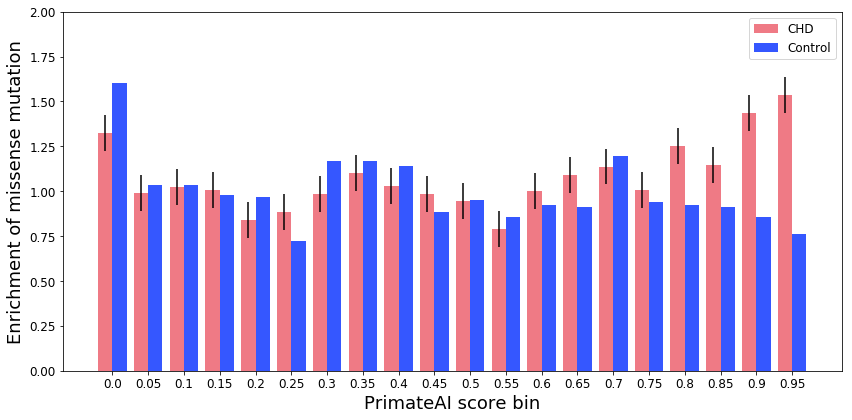

In [126]:
score_bin = []
chd_bin = []
control_bin = []
for i in range(0,20):
    score_bin.append((i) /20)
    chd_bin.append((sum(primateAI_chd > i/20) - sum(primateAI_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    #chd_bin.append((sum(MSVM_chd > i/20) - sum(MSVM_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    control_bin.append((sum(primateAI_control > i/20) - sum(primateAI_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    #control_bin.append((sum(MSVM_control > i/20) - sum(MSVM_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    
    #print(i/20, (sum(primateAI_chd > i/20) - sum(primateAI_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    #print(i/20, (sum(primateAI_chd > i/20)) / (0.033918181658547986 *3835 * (20-i)))
    #print(i/20, (sum(primateAI_control > i/20) - sum(primateAI_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    
"""    
labels = ['Synonymous', 'Missense', 'Loss-of-function']
chd_rate = np.array([1011, 2781, 586]) / 3835
control_rate = np.array([625, 1459, 238]) / 2165
expected_rate = np.array([0.1430312559818024,0.3396175777975223,0.05366858450284304]) * 2
"""
plt.rcParams.update({'font.size': 12})
x = np.arange(len(score_bin))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width / 2, chd_bin, width, label='CHD', yerr = 0.1, color = "#ef7a85")
#rects2 = ax.bar(x, control_rate, width, label='Control', color = "#3557ff")
rects3 = ax.bar(x + width / 2, control_bin, width, label='Control', color = "#3557ff")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enrichment of missense mutation', fontsize=18)
ax.set_xlabel('PrimateAI score bin', fontsize=18)
#ax.set_title('Mutation type')
ax.set_xticks(x)
ax.set_xticklabels(score_bin)
ax.set_ylim((0,2))
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height + 0.02),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

fig.tight_layout()



plt.show()

In [109]:
len(primateAI_chd)

113

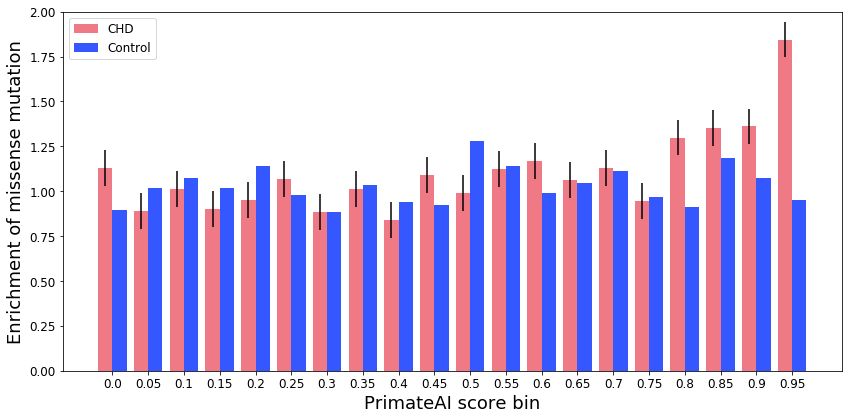

In [93]:
score_bin = []
chd_bin = []
control_bin = []
for i in range(0,20):
    score_bin.append((i) /20)
    #chd_bin.append((sum(primateAI_chd > i/20) - sum(primateAI_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    chd_bin.append((sum(MSVM_chd > i/20) - sum(MSVM_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    #control_bin.append((sum(primateAI_control > i/20) - sum(primateAI_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    control_bin.append((sum(MSVM_control > i/20) - sum(MSVM_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    
    #print(i/20, (sum(primateAI_chd > i/20) - sum(primateAI_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    #print(i/20, (sum(primateAI_chd > i/20)) / (0.033918181658547986 *3835 * (20-i)))
    #print(i/20, (sum(primateAI_control > i/20) - sum(primateAI_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    
    
labels = ['Synonymous', 'Missense', 'Loss-of-function']
chd_rate = np.array([1011, 2781, 586]) / 3835
control_rate = np.array([625, 1459, 238]) / 2165
expected_rate = np.array([0.1430312559818024,0.3396175777975223,0.05366858450284304]) * 2

plt.rcParams.update({'font.size': 12})
x = np.arange(len(score_bin))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width / 2, chd_bin, width, label='CHD', yerr = 0.1, color = "#ef7a85")
#rects2 = ax.bar(x, control_rate, width, label='Control', color = "#3557ff")
rects3 = ax.bar(x + width / 2, control_bin, width, label='Control', color = "#3557ff")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enrichment of missense mutation', fontsize=18)
ax.set_xlabel('PrimateAI score bin', fontsize=18)
#ax.set_title('Mutation type')
ax.set_xticks(x)
ax.set_xticklabels(score_bin)
ax.set_ylim((0,2))
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height + 0.02),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

fig.tight_layout()



plt.show()

In [246]:
#print((all_chd_scores[all_chd_scores['PrimateAI_score'] > 0.749])[all_chd_scores['PrimateAI_score'] < 0.751])
#print((all_chd_scores[all_chd_scores['PrimateAI_score'] > 0.849])[all_chd_scores['PrimateAI_score'] < 0.851])
#print((all_chd_scores[all_chd_scores['MVP_rankscore'] > 0.8])[all_chd_scores['MVP_rankscore'] < 0.81])
#print(hum_chd_scores[hum_chd_scores['PrimateAI_rankscore'] > 0.9])

In [56]:
print(all_chd_scores[all_chd_scores['genename']=='DSCAML1']['MetaSVM_rankscore'])
print(all_chd_scores[all_chd_scores['genename']=='DSCAML1']['PrimateAI_score'])
print(all_chd_scores[all_chd_scores['genename']=='LZTR1']['PrimateAI_score'])
print(all_chd_control_scores[all_chd_control_scores['genename']=='LZTR1']['PrimateAI_score'])
print(all_chd_control_scores[all_chd_control_scores['genename']=='LZTR1']['REVEL_rankscore'])
print(all_chd_scores[all_chd_scores['genename']=='OSBP'])

1169    0.88266
1170    0.68804
1171    0.88714
1172    0.36946
1173    0.40972
2494    0.42521
Name: MetaSVM_rankscore, dtype: object
1169    0.881842
1170    0.855462
1171    0.817308
1172     0.51352
1173    0.915188
2494    0.750235
Name: PrimateAI_score, dtype: object
1985    0.853291
1986     0.84609
1987    0.857935
Name: PrimateAI_score, dtype: object
1160    0.781375
1185    0.928225
Name: PrimateAI_score, dtype: object
1160    0.6331
1185    0.9844
Name: REVEL_rankscore, dtype: object
                 sample chr       pos ref alt genename  effects  \
1105         GT04013812  11  59610561   G   A     OSBP  p.R131C   
2685  SC_CHD_FY35816747  11  59600504   G   C     OSBP  p.P435A   

     Polyphen2_HDIV_score Polyphen2_HDIV_rankscore Polyphen2_HVAR_score  \
1105                    1                  0.90584                0.998   
2685                    1                  0.90584                0.996   

            ...         MVP_score MVP_rankscore MPC_score MPC_rankscore 

In [ ]:
chd_score_dict

## Counting the number of mutations in chd data

In [73]:
mis_gene_dict = {}
gene_id_dict = {}
mut_list = []
with open("chd.missense.uniq.txt", 'r') as chd_mis_f:
    chd_mis_reader = csv.reader(chd_mis_f, delimiter = '\t')
    for row in chd_mis_reader:
        chrom = row[0].split('_')[0][3:]
        pos = row[0].split('_')[1]
        ref = row[0].split('_')[2].split('/')[0]
        alt = row[0].split('_')[2].split('/')[1]
        gene_id = row[3]

        mut = row[0]
        if mut in mut_list:
            print(row)
        mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            #if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
            gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            #if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":
            gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        #gene = gene_id_dict[gene_id]
        #print(gene)
            
        mis_gene_dict[(chrom, pos, ref, alt)] = gene
        if gene_id not in gene_id_dict:
            gene_id_dict[gene_id] = gene

In [74]:
plof_count_dict = {}
mut_list = []
gene_list = []
with open("chd.pLoF.txt", 'r') as chd_plof_f:
    chd_plof_reader = csv.reader(chd_plof_f, delimiter = '\t')
    for row in chd_plof_reader:
        gene_id = row[3]
        mut = row[0]

        if mut in mut_list:
            print(row)
        mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        
        #gene = gene_id_dict[gene_id]
        #print(gene)
        if gene not in gene_list:
            gene_list.append(gene)
        if gene in plof_count_dict:
            plof_count_dict[gene] += 1
        else:
            plof_count_dict[gene] = 1
            
        if gene_id not in gene_id_dict:
            gene_id_dict[gene_id] = gene

In [76]:
chd_inherited_plof_count_dict = {}
mut_list = []
#gene_list = []
with open("chd.inherited.pLoF.txt", 'r') as chd_plof_f:
    
    chd_plof_reader = csv.reader(chd_plof_f, delimiter = '\t')
    for row in chd_plof_reader:
        gene_id = row[3]
        mut = row[0]

        #if mut in mut_list:
        #    print(row[13].split(';')[2].split('=')[1], row[13].split(';')[3].split('=')[1])
        #mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        
        #if "-" in gene:
        #   print(gene)
        
        #gene = gene_id_dict[gene_id]
        #print(gene)
        if gene not in gene_list:
            gene_list.append(gene)
        if gene in chd_inherited_plof_count_dict:
            chd_inherited_plof_count_dict[gene] += 1
        else:
            chd_inherited_plof_count_dict[gene] = 1
            
        if gene_id not in gene_id_dict:
            gene_id_dict[gene_id] = gene

In [78]:
control_inherited_plof_count_dict = {}
mut_list = []
#gene_list = []
with open("control.inherited.pLoF.txt", 'r') as control_plof_f:
    control_plof_reader = csv.reader(control_plof_f, delimiter = '\t')
    for row in control_plof_reader:
        gene_id = row[3]
        mut = row[0]

        #if mut in mut_list:
        #    print(row[13].split(';')[2].split('=')[1], row[13].split(';')[3].split('=')[1])
        #mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        
        #gene = gene_id_dict[gene_id]
        #print(gene)
        if gene not in gene_list:
            gene_list.append(gene)
        if gene in control_inherited_plof_count_dict:
            control_inherited_plof_count_dict[gene] += 1
        else:
            control_inherited_plof_count_dict[gene] = 1
            
        if gene_id not in gene_id_dict:
            gene_id_dict[gene_id] = gene

In [80]:
misA_count_dict = {}
misB_count_dict = {}
mis_count_dict = {}
#gene_list = []

# Aggregating CHD exome variant data

with open('seidman.hg38.final.bed', 'r') as seidman_f:
    seidman_var_reader = csv.reader(seidman_f, delimiter = '\t')
    for row in seidman_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if var in chd_score_dict:
            if chd_score_dict[var][24] != None and var in mis_gene_dict:
            #if chd_score_dict[var][21] != None and var in mis_gene_dict:
                gene = mis_gene_dict[var]
                if gene not in gene_list:
                    gene_list.append(gene)
                if gene in mis_count_dict:
                    mis_count_dict[gene] += 1
                else:
                    mis_count_dict[gene] = 1
                
                
                if float(chd_score_dict[var][24]) > 0.85:
                #if float(chd_score_dict[var][21]) > 0.9:
                    gene = mis_gene_dict[var]
                    if gene not in gene_list:
                        gene_list.append(gene)
                    if gene in misA_count_dict:
                        misA_count_dict[gene] += 1
                    else:
                        misA_count_dict[gene] = 1
                elif float(chd_score_dict[var][24]) > 0.75:
                #elif float(chd_score_dict[var][21]) > 0.75:
                    gene = mis_gene_dict[var]
                    if gene not in gene_list:
                        gene_list.append(gene)                    
                    if gene in misB_count_dict:
                        misB_count_dict[gene] += 1
                    else:
                        misB_count_dict[gene] = 1
                        
with open('s_chd.hg38.final.bed', 'r') as s_chd_f:
    s_chd_var_reader = csv.reader(s_chd_f, delimiter = '\t')
    for row in s_chd_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            if chd_score_dict[var][24] != None and var in mis_gene_dict:
            #if chd_score_dict[var][21] != None and var in mis_gene_dict:
                gene = mis_gene_dict[var]
                if gene not in gene_list:
                    gene_list.append(gene)
                if gene in mis_count_dict:
                    mis_count_dict[gene] += 1
                else:
                    mis_count_dict[gene] = 1
                    
                if float(chd_score_dict[var][24]) > 0.85:
                #if float(chd_score_dict[var][21]) > 0.9:
                    gene = mis_gene_dict[var]
                    if gene not in gene_list:
                        gene_list.append(gene)
                    if gene in misA_count_dict:
                        misA_count_dict[gene] += 1
                    else:
                        misA_count_dict[gene] = 1
                elif float(chd_score_dict[var][24]) > 0.75:
                #elif float(chd_score_dict[var][21]) > 0.75:
                    gene = mis_gene_dict[var]
                    if gene not in gene_list:
                        gene_list.append(gene)
                    if gene in misB_count_dict:
                        misB_count_dict[gene] += 1
                    else:
                        misB_count_dict[gene] = 1

                
with open('ns_chd.hg38.final.bed', 'r') as ns_chd_f:
    ns_chd_var_reader = csv.reader(ns_chd_f, delimiter = '\t')
    for row in ns_chd_var_reader:
        #print(row)
        chrom = row[0][3:]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        sample = row[5]
        var = (chrom, pos, ref, alt)
        if (var) in chd_score_dict:
            if chd_score_dict[var][24] != None and var in mis_gene_dict:
            #if chd_score_dict[var][21] != None and var in mis_gene_dict:
                gene = mis_gene_dict[var]
                if gene not in gene_list:
                    gene_list.append(gene)
                if gene in mis_count_dict:
                    mis_count_dict[gene] += 1
                else:
                    mis_count_dict[gene] = 1
                    
                if float(chd_score_dict[var][24]) > 0.85:
                #if float(chd_score_dict[var][21]) > 0.9:
                    gene = mis_gene_dict[var]
                    if gene not in gene_list:
                        gene_list.append(gene)
                    if gene in misA_count_dict:
                        misA_count_dict[gene] += 1
                    else:
                        misA_count_dict[gene] = 1
                elif float(chd_score_dict[var][24]) > 0.75:
                #elif float(chd_score_dict[var][21]) > 0.75:
                    gene = mis_gene_dict[var]
                    if gene not in gene_list:
                        gene_list.append(gene)
                    if gene in misB_count_dict:
                        misB_count_dict[gene] += 1
                    else:
                        misB_count_dict[gene] = 1               

In [82]:
syn_count_dict = {}
mut_list = []
#gene_list = []
with open("chd.synonymous.uniq.txt", 'r') as chd_syn_f:
    chd_syn_reader = csv.reader(chd_syn_f, delimiter = '\t')
    for row in chd_syn_reader:

        gene_id = row[3]
        mut = row[0]
        if mut in mut_list:
            print(row)
        mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            #if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
            gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            #if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":
            gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        #gene = gene_id_dict[gene_id]
        #print(gene)
        
        if gene not in gene_list:
            gene_list.append(gene)
        if gene in syn_count_dict:
            syn_count_dict[gene] += 1
        else:
            syn_count_dict[gene] = 1

        if gene_id not in gene_id_dict:
            gene_id_dict[gene_id] = gene

In [105]:
mu_syn_dict = {}
mu_mis_dict = {}
mu_plof_dict = {}
mu_plof_samocha_dict = {}
gnomad_dict = {}
gnomad_gene_to_id_dict = {}
gnomad_gene_to_tid_dict = {}
splice_tid_to_gene_dict = {}

with open('gnomad.v2.1.1.mu_rate.09_04_20.txt', 'r') as mu_f:
    mu_reader = csv.reader(mu_f, delimiter = '\t')
    header = next(mu_reader)
    print(header)
    for row in mu_reader:
        gene = row[0]
        gene_id = row[8]
        trans_id = row[1]
        gnomad_dict[gene] = row
        gnomad_gene_to_id_dict[gene] = gene_id
        gnomad_gene_to_tid_dict[gene] = trans_id

        
        mu_syn = float(row[3])
        mu_mis = float(row[2])
        mu_syn_dict[gene] = mu_syn
        mu_mis_dict[gene] = mu_mis

    
with open('samocha2014.mu_rate.txt', 'r') as mu_f:
    mu_reader = csv.reader(mu_f, delimiter = '\t')
    header = next(mu_reader)
    print(header)
    for row in mu_reader:
        gene = row[0]
        
        if row[6] != "NA":
            mu_plof = 10**float(row[5])+ 0.96 * 10**float(row[6]) + 1.48 * 10**float(row[7])
        else:
            mu_plof = 10**float(row[5])+ 1.48 * 10**float(row[7])        
        mu_plof_samocha_dict[gene] = mu_plof        


with open('cryptic_splice_mutation_rate.protein_coding.1_22_X.txt', 'r') as mu_f:
    mu_reader = csv.reader(mu_f, delimiter = '\t')
    header = next(mu_reader)
    print(header)
    for row in mu_reader:
        gene = row[0]
        trans_id = row[1].split('.')[0]
        splice_tid_to_gene_dict[trans_id] = gene
        
        if row[6] != "NA":
            mu_plof = 10**float(row[5]) + 5.8 * 10**float(row[6]) + 1.15 * 10**float(row[10])
        elif row[10] != "NA":
            mu_plof = 10**float(row[5]) + 1.15 * 10**float(row[10])
        else:
            print(row)
    
        mu_plof_dict[gene] = mu_plof


['gene', 'transcript', 'mu_mis', 'mu_syn', 'mu_lof', 'pLI', 'oe_lof_upper_bin', 'oe_lof_upper_bin_6', 'gene_id', 'gene_type', 'chromosome', 'start_position', 'end_position']
['gene', 'bp', 'all', 'syn', 'mis', 'non', 'splice_site', 'frameshift']
['symbol', 'enst_transcript_id', 'chrom', 'length', 'missense_rate', 'nonsense_rate', 'splice_lof_rate', 'splice_region_rate', 'synonymous_rate', 'cryptic_splice_rate', 'frameshift_rate']


In [106]:
TADA_count = []
all_mut_count = []
count = 0

for gene in mu_syn_dict:
    passed = False
    mu_syn = mu_syn_dict[gene]
    mu_mis = mu_mis_dict[gene]

    gene_id = gnomad_gene_to_id_dict[gene]

    if gene not in mu_plof_dict:
        
        if gnomad_gene_to_tid_dict[gene] not in splice_tid_to_gene_dict:
            #print(gene, gnomad_gene_to_id_dict[gene])
            if gene in mu_plof_samocha_dict:
                #print(gene)
                mu_plof = mu_plof_samocha_dict[gene]
                passed = True
                count += 1
            elif gene_id in gene_id_dict:
                if gene_id_dict[gene_id] in mu_plof_samocha_dict:
                    mu_plof = mu_plof_samocha_dict[gene_id_dict[gene_id]]
                    passed = True
                    count += 1
                elif gene in gene_list and gnomad_dict[gene][4] != "NA":
                    mu_plof = float(gnomad_dict[gene][4])
                    passed = True
                    count += 1
                elif gene_id_dict[gene_id] in gene_list and gnomad_dict[gene_id_dict[gene_id]][4] != "NA":
                    mu_plof = float(gnomad_dict[gene][4])
                    passed = True
                    count += 1
        else:
            mu_plof = mu_plof_dict[splice_tid_to_gene_dict[gnomad_gene_to_tid_dict[gene]]]
            passed = True
            count += 1

    else:
        mu_plof = mu_plof_dict[gene]
        passed = True
        count += 1
        
    if gnomad_dict[gene][5] != "NA":
        pLI = gnomad_dict[gene][5]
    else:
        pLI = -1
    if gnomad_dict[gene][6] != "NA":
        pLI_bin = gnomad_dict[gene][6]
    else:
        pLI_bin = 10
    
    chrom = gnomad_dict[gene][10]
    
    #if gene == "ASB3":
    #    print(gene_id, gene, gnomad_dict[gene_id_dict[gene_id]])
 
    if gene_id in gene_id_dict:
        gene = gene_id_dict[gene_id]
  
    
    if passed:
        if gene == "UGT1A1":
            print(gene, gene_id)
        countMis = mis_count_dict[gene] if gene in mis_count_dict else 0
        countA = misA_count_dict[gene] if gene in misA_count_dict else 0
        countB = misB_count_dict[gene] if gene in misB_count_dict else 0
        countpLoF = plof_count_dict[gene] if gene in plof_count_dict else 0
        countSyn = syn_count_dict[gene] if gene in syn_count_dict else 0
        countCHD_inh_pLoF = chd_inherited_plof_count_dict[gene] if gene in chd_inherited_plof_count_dict else 0
        countCTRL_inh_pLoF = control_inherited_plof_count_dict[gene] if gene in control_inherited_plof_count_dict else 0
        
        chrx = 0.7233377

        if chrom == 'X':
            all_mut_count.append((gene, pLI, pLI_bin, mu_mis*chrx, countMis, mu_syn*chrx, countSyn, mu_plof*chrx, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF))
            TADA_count.append((gene, mu_mis*0.1*chrx, countA, mu_mis*0.155*chrx, countB, mu_plof*chrx, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF))
        else:
            all_mut_count.append((gene, pLI, pLI_bin, mu_mis, countMis, mu_syn, countSyn, mu_plof, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF)) 
            TADA_count.append((gene, mu_mis*0.1, countA, mu_mis*0.155, countB, mu_plof, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF))


all_mut_count = pd.DataFrame(np.array(all_mut_count),columns=['gene.id', 'pLI', 'pLI_bin', 'mu_mis','dn_mis','mu_syn','dn_syn','mu_lof','dn_lof','chd_inh_lof', 'ctrl_inh_lof'])            
all_mut_count = all_mut_count.astype({'pLI': 'float64', 'pLI_bin' : 'int32', 'mu_mis': 'float64', 'mu_syn': 'float64', 'mu_lof': 'float64', 'dn_mis': 'int32', 'dn_syn': 'int32', 'dn_lof': 'int32'})


TADA_count = pd.DataFrame(np.array(TADA_count),columns=['gene.id','mut.cls1','dn.cls1','mut.cls2','dn.cls2','mut.cls3','dn.cls3', 'case.cls3', 'ctrl.cls3'])
TADA_count = TADA_count.astype({'mut.cls1': 'float64', 'mut.cls2': 'float64', 'mut.cls3': 'float64', 'dn.cls1': 'int32', 'dn.cls2': 'int32', 'dn.cls3': 'int32', 'case.cls3': 'int32', 'ctrl.cls3': 'int32'})

all_mut_count.to_csv('mut_count_chd.txt', header=True, sep = '\t', index=False)
TADA_count.to_csv('TADAcount_chd_new.txt', header=True, sep = '\t', index=False)

print(count)
print(sum(TADA_count['mut.cls1']), sum(TADA_count['mut.cls2']), sum(TADA_count['mut.cls3']))
print(sum(TADA_count['mut.cls1'])*2*3835, sum(TADA_count['mut.cls2'])*2*3835, sum(TADA_count['mut.cls3'])*2*3835)
print(sum(TADA_count['dn.cls1']), sum(TADA_count['dn.cls2']), sum(TADA_count['dn.cls3']), sum(TADA_count['case.cls3']), sum(TADA_count['ctrl.cls3']))

print(sum(all_mut_count['mu_mis']), sum(all_mut_count['mu_syn']), sum(all_mut_count['mu_lof']))
print(sum(all_mut_count['mu_mis'])*2*3835, sum(all_mut_count['mu_syn'])*2*3835, sum(all_mut_count['mu_lof'])*2*3835)
print(sum(all_mut_count['dn_mis']), sum(all_mut_count['dn_syn']), sum(all_mut_count['dn_lof']))
print(sum(all_mut_count[all_mut_count['pLI']>0.5]['mu_lof'])*2*3835, sum(all_mut_count['pLI']<0.9), sum(all_mut_count[all_mut_count['pLI']<0.5]['dn_lof']))
for i in range(0,10):
    print(i, sum(all_mut_count[all_mut_count['pLI_bin']<=i]['dn_lof']) / (sum(all_mut_count[all_mut_count['pLI_bin']<=i]['mu_lof'])*2*3835), sum(all_mut_count[all_mut_count['pLI_bin']>i]['dn_lof']) / (sum(all_mut_count[all_mut_count['pLI_bin']>i]['mu_lof'])*2*3835))
    print(i, sum(all_mut_count[all_mut_count['pLI_bin']==i]['dn_lof']) / (sum(all_mut_count[all_mut_count['pLI_bin']==i]['mu_lof'])*2*3835))

UGT1A1 ENSG00000241635
19165
0.033918181658547986 0.052573181570749854 0.05358585436399946
260.15245332106304 403.23630264765137 411.00350297187583
395 450 586 11651 12655
0.33918181658548263 0.1428583610100913 0.05358585436399946
2601.524533210652 1095.7236289474004 411.00350297187583
2781 1046 586
126.51073274636597 16114 273
0 3.1158969809292802 1.0479161354948494
0 3.1158969809292802
1 2.357475655689101 0.9832822212145244
1 1.3625360728871079
2 2.0406742896607057 0.9356794049949106
2 1.2012556418626532
3 1.829671701738297 0.9175790311215237
3 1.0062054174821635
4 1.6464795160263985 0.9905969619745002
4 0.6864952841616624
5 1.5600799278402286 1.0052170509984355
5 0.9531306552527081
6 1.5008863327465751 1.0369643900049366
6 0.9410871282025612
7 1.479883219172819 0.9243463746060875
7 1.2069964725945344
8 1.4300924490296714 1.338796510095374
8 0.5337769754201305
9 1.4361541610822293 0.27280537439005853
9 1.5868169636549831


In [ ]:
TADA_count = []
all_mut_count = []
count = 0

for gene in mu_syn_dict:
    passed = False
    mu_syn = mu_syn_dict[gene]
    mu_mis = mu_mis_dict[gene]

    gene_id = gnomad_gene_to_id_dict[gene]

    if gene not in mu_plof_dict:
        
        if gnomad_gene_to_tid_dict[gene] not in splice_tid_to_gene_dict:
            #print(gene, gnomad_gene_to_id_dict[gene])
            if gene in mu_plof_samocha_dict:
                #print(gene)
                mu_plof = mu_plof_samocha_dict[gene]
                passed = True
                count += 1
            elif gene_id in gene_id_dict:
                if gene_id_dict[gene_id] in mu_plof_samocha_dict:
                    mu_plof = mu_plof_samocha_dict[gene_id_dict[gene_id]]
                    passed = True
                    count += 1
                elif gene in gene_list and gnomad_dict[gene][4] != "NA":
                    mu_plof = float(gnomad_dict[gene][4])
                    passed = True
                    count += 1
                elif gene_id_dict[gene_id] in gene_list and gnomad_dict[gene_id_dict[gene_id]][4] != "NA":
                    mu_plof = float(gnomad_dict[gene][4])
                    passed = True
                    count += 1
        else:
            mu_plof = mu_plof_dict[splice_tid_to_gene_dict[gnomad_gene_to_tid_dict[gene]]]
            passed = True
            count += 1

    else:
        mu_plof = mu_plof_dict[gene]
        passed = True
        count += 1
        
    if gnomad_dict[gene][5] != "NA":
        pLI = gnomad_dict[gene][5]
    else:
        pLI = -1
    if gnomad_dict[gene][6] != "NA":
        pLI_bin = gnomad_dict[gene][6]
    else:
        pLI_bin = 10
    
    chrom = gnomad_dict[gene][10]
    
    #if gene == "ASB3":
    #    print(gene_id, gene, gnomad_dict[gene_id_dict[gene_id]])
 
    if gene_id in gene_id_dict:
        gene = gene_id_dict[gene_id]
  
    
    if passed:
        if gene == "UGT1A1":
            print(gene, gene_id)
        countMis = mis_count_dict[gene] if gene in mis_count_dict else 0
        countA = misA_count_dict[gene] if gene in misA_count_dict else 0
        countB = misB_count_dict[gene] if gene in misB_count_dict else 0
        countpLoF = plof_count_dict[gene] if gene in plof_count_dict else 0
        countSyn = syn_count_dict[gene] if gene in syn_count_dict else 0
        countCHD_inh_pLoF = chd_inherited_plof_count_dict[gene] if gene in chd_inherited_plof_count_dict else 0
        countCTRL_inh_pLoF = control_inherited_plof_count_dict[gene] if gene in control_inherited_plof_count_dict else 0
        
        chrx = 0.7233377

        if chrom == 'X':
            all_mut_count.append((gene, pLI, pLI_bin, mu_mis*chrx, countMis, mu_syn*chrx, countSyn, mu_plof*chrx, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF))
            TADA_count.append((gene, mu_mis*0.1*chrx, countA, mu_mis*0.155*chrx, countB, mu_plof*chrx, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF))
        else:
            all_mut_count.append((gene, pLI, pLI_bin, mu_mis, countMis, mu_syn, countSyn, mu_plof, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF)) 
            TADA_count.append((gene, mu_mis*0.1, countA, mu_mis*0.155, countB, mu_plof, countpLoF, countCHD_inh_pLoF, countCTRL_inh_pLoF))


all_mut_count = pd.DataFrame(np.array(all_mut_count),columns=['gene.id', 'pLI', 'pLI_bin', 'mu_mis','dn_mis','mu_syn','dn_syn','mu_lof','dn_lof','chd_inh_lof', 'ctrl_inh_lof'])            
all_mut_count = all_mut_count.astype({'pLI': 'float64', 'pLI_bin' : 'int32', 'mu_mis': 'float64', 'mu_syn': 'float64', 'mu_lof': 'float64', 'dn_mis': 'int32', 'dn_syn': 'int32', 'dn_lof': 'int32'})


TADA_count = pd.DataFrame(np.array(TADA_count),columns=['gene.id','mut.cls1','dn.cls1','mut.cls2','dn.cls2','mut.cls3','dn.cls3', 'case.cls3', 'ctrl.cls3'])
TADA_count = TADA_count.astype({'mut.cls1': 'float64', 'mut.cls2': 'float64', 'mut.cls3': 'float64', 'dn.cls1': 'int32', 'dn.cls2': 'int32', 'dn.cls3': 'int32', 'case.cls3': 'int32', 'ctrl.cls3': 'int32'})

all_mut_count.to_csv('mut_count_chd.txt', header=True, sep = '\t', index=False)
TADA_count.to_csv('TADAcount_chd_new.txt', header=True, sep = '\t', index=False)

print(count)
print(sum(TADA_count['mut.cls1']), sum(TADA_count['mut.cls2']), sum(TADA_count['mut.cls3']))
print(sum(TADA_count['mut.cls1'])*2*3835, sum(TADA_count['mut.cls2'])*2*3835, sum(TADA_count['mut.cls3'])*2*3835)
print(sum(TADA_count['dn.cls1']), sum(TADA_count['dn.cls2']), sum(TADA_count['dn.cls3']), sum(TADA_count['case.cls3']), sum(TADA_count['ctrl.cls3']))

print(sum(all_mut_count['mu_mis']), sum(all_mut_count['mu_syn']), sum(all_mut_count['mu_lof']))
print(sum(all_mut_count['mu_mis'])*2*3835, sum(all_mut_count['mu_syn'])*2*3835, sum(all_mut_count['mu_lof'])*2*3835)
print(sum(all_mut_count['dn_mis']), sum(all_mut_count['dn_syn']), sum(all_mut_count['dn_lof']))
print(sum(all_mut_count[all_mut_count['pLI']>0.5]['mu_lof'])*2*3835, sum(all_mut_count['pLI']<0.9), sum(all_mut_count[all_mut_count['pLI']<0.5]['dn_lof']))
for i in range(0,10):
    print(i, sum(all_mut_count[all_mut_count['pLI_bin']<=i]['dn_lof']) / (sum(all_mut_count[all_mut_count['pLI_bin']<=i]['mu_lof'])*2*3835), sum(all_mut_count[all_mut_count['pLI_bin']>i]['dn_lof']) / (sum(all_mut_count[all_mut_count['pLI_bin']>i]['mu_lof'])*2*3835))
    print(i, sum(all_mut_count[all_mut_count['pLI_bin']==i]['dn_lof']) / (sum(all_mut_count[all_mut_count['pLI_bin']==i]['mu_lof'])*2*3835))

In [108]:
print(11651 / 12655 * 3578 / 2871)
print(1 + 0.1473824334435514 / 0.023)
print((11651 + 12655) / (3578 + 2871) / 19165)

1.1473824334435514
7.407931888850061
0.00019665830562760647


In [731]:
print(all_mut_count[all_mut_count['pLI_bin'] > 1 ][all_mut_count['dn_lof'] > 1])

      gene.id           pLI  pLI_bin    mu_mis  dn_mis    mu_syn  dn_syn  \
3905   AKAP12  3.566600e-02        2  0.000052       0  0.000027       0   
4892     PTEN  2.565100e-01        2  0.000011       0  0.000004       0   
5148    GATA4  4.930800e-01        2  0.000013       0  0.000007       0   
5652    KDM5B  7.910200e-15        2  0.000045       0  0.000016       0   
5736    TECTA  2.986300e-16        2  0.000082       2  0.000042       0   
8175    ASXL1  1.251100e-14        4  0.000050       0  0.000021       0   
9089      ELN  2.142900e-14        4  0.000027       0  0.000014       0   
11351    EVC2  1.020700e-34        5  0.000042       0  0.000019       0   
13634  SAMD11  4.768100e-14        7  0.000021       0  0.000009       0   
14502   MSLNL  3.048900e-26        7  0.000042       0  0.000020       0   

         mu_lof  dn_lof  
3905   0.000008       2  
4892   0.000002       2  
5148   0.000002       2  
5652   0.000008       4  
5736   0.000011       2  
8175   

/Users/raehoon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Counting the de novo mutations in control data

In [559]:
ctrl_mis_gene_dict = {}
ctrl_gene_id_dict = {}
ctrl_mut_list = []
with open("control.missense.uniq.txt", 'r') as ctrl_mis_f:
    ctrl_mis_reader = csv.reader(ctrl_mis_f, delimiter = '\t')
    for row in ctrl_mis_reader:
        chrom = row[0].split('_')[0][3:]
        pos = row[0].split('_')[1]
        ref = row[0].split('_')[2].split('/')[0]
        alt = row[0].split('_')[2].split('/')[1]
        gene_id = row[3]

        mut = row[0]
        if mut in ctrl_mut_list:
            print(row)
        ctrl_mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            #if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
            gene = row[13].split(';')[2].split('=')[1]
            
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            #if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":

            gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        #gene = gene_id_dict[gene_id]
        #print(gene)

            
        ctrl_mis_gene_dict[(chrom, pos, ref, alt)] = gene
        if gene_id not in ctrl_gene_id_dict:
            ctrl_gene_id_dict[gene_id] = gene

In [560]:
ctrl_plof_count_dict = {}
ctrl_mut_list = []
ctrl_gene_list = []
with open("control.pLoF.txt", 'r') as control_plof_f:
    control_plof_reader = csv.reader(control_plof_f, delimiter = '\t')
    for row in control_plof_reader:
        gene_id = row[3]
        mut = row[0]

        if mut in ctrl_mut_list:
            print(row)
        ctrl_mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            if row[13].split(';')[3] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            if row[13].split(';')[4] == "SYMBOL_SOURCE=HGNC":
                gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        
        #gene = gene_id_dict[gene_id]
        #print(gene)
        if gene not in ctrl_gene_list:
            ctrl_gene_list.append(gene)
        
        if gene in ctrl_plof_count_dict:
            ctrl_plof_count_dict[gene] += 1
        else:
            ctrl_plof_count_dict[gene] = 1
            
        if gene_id not in ctrl_gene_id_dict:
            ctrl_gene_id_dict[gene_id] = gene

In [779]:
ctrl_misA_count_dict = {}
ctrl_misB_count_dict = {}
ctrl_mis_count_dict = {}
count = 0

# Aggregating CHD exome variant data

with open('autism.control.mutations.hg19.duplicate_filtered.txt', 'r') as ctrl_mis_f:
    ctrl_var_reader = csv.reader(ctrl_mis_f, delimiter = '\t')
    for row in ctrl_var_reader:
        #print(row)
        chrom = row[0]
        pos = row[1]
        ref = row[2]
        alt = row[3]
        sample = row[4]
        if (chrom,pos,ref,alt) in mis_hg19_to_hg38_dict:
            var = mis_hg19_to_hg38_dict[(chrom,pos,ref,alt)]
            if var in control_score_hg38_dict:
                #if control_score_hg38_dict[var][24] != None and var in ctrl_mis_gene_dict:
                if control_score_hg38_dict[var][21] != None and var in ctrl_mis_gene_dict:
                    gene = ctrl_mis_gene_dict[var]

                    if gene not in ctrl_gene_list:
                        ctrl_gene_list.append(gene)

                    if gene in ctrl_mis_count_dict:
                        ctrl_mis_count_dict[gene] += 1
                    else:
                        ctrl_mis_count_dict[gene] = 1

                    #if float(control_score_hg38_dict[var][24]) > 0.85:
                    if float(control_score_hg38_dict[var][21]) > 0.9:
                        if gene in ctrl_misA_count_dict:
                            ctrl_misA_count_dict[gene] += 1
                        else:
                            ctrl_misA_count_dict[gene] = 1
                    #elif float(control_score_hg38_dict[var][24]) > 0.75:
                    elif float(control_score_hg38_dict[var][21]) > 0.75:    
                        if gene in ctrl_misB_count_dict:
                            ctrl_misB_count_dict[gene] += 1
                        else:
                            ctrl_misB_count_dict[gene] = 1

In [571]:
ctrl_syn_count_dict = {}
ctrl_mut_list = []
with open("control.synonymous.txt", 'r') as ctrl_syn_f:
    ctrl_syn_reader = csv.reader(ctrl_syn_f, delimiter = '\t')
    for row in ctrl_syn_reader:

        gene_id = row[3]
        mut = row[0]
        # There are recurrent mutations, so I left them in.
        #if mut in ctrl_mut_list:
        #    print(row)
        #ctrl_mut_list.append(mut)
        
        if row[13].split(';')[2].split('=')[0] == "SYMBOL":
            gene = row[13].split(';')[2].split('=')[1]
        elif row[13].split(';')[3].split('=')[0] == "SYMBOL":
            gene = row[13].split(';')[3].split('=')[1]
        else:
            print("what is this gene?")
        #gene = gene_id_dict[gene_id]
        #print(gene)
        
        if gene not in ctrl_gene_list:
            ctrl_gene_list.append(gene)
        if gene in ctrl_syn_count_dict:
            ctrl_syn_count_dict[gene] += 1
        else:
            ctrl_syn_count_dict[gene] = 1

        if gene_id not in ctrl_gene_id_dict:
            ctrl_gene_id_dict[gene_id] = gene

In [780]:
ctrl_TADA_count = []
ctrl_mut_count = []
count = 0
count_sam = 0
count_sat = 0
count_sat = 0

for gene in mu_syn_dict:
    passed = False
    mu_syn = mu_syn_dict[gene]
    mu_mis = mu_mis_dict[gene]

    gene_id = gnomad_gene_to_id_dict[gene]
    
  
    if gene not in mu_plof_dict:
        if gnomad_gene_to_tid_dict[gene] not in splice_tid_to_gene_dict:
            #print(gene, gnomad_gene_to_id_dict[gene])
            if gene in mu_plof_samocha_dict:
                #print(gene)
                mu_plof = mu_plof_samocha_dict[gene]
                passed = True
                count += 1
            elif gene_id in ctrl_gene_id_dict:
                if ctrl_gene_id_dict[gene_id] in mu_plof_samocha_dict:
                    mu_plof = mu_plof_samocha_dict[gene_id_dict[gene_id]]
                    passed = True
                    count += 1
                elif gene in gene_list:
                    mu_plof = float(gnomad_dict[gene][4])
                    passed = True
                    count += 1
        else:
            mu_plof = mu_plof_dict[splice_tid_to_gene_dict[gnomad_gene_to_tid_dict[gene]]]
            passed = True
            count += 1
    else:
        mu_plof = mu_plof_dict[gene]
        passed = True
        count += 1
        
    if gnomad_dict[gene][5] != "NA":
        pLI = gnomad_dict[gene][5]
    else:
        pLI = -1
    if gnomad_dict[gene][6] != "NA":
        pLI_bin = gnomad_dict[gene][6]
    else:
        pLI_bin = 10
    
    chrom = gnomad_dict[gene][10]
    
    if gene_id in ctrl_gene_id_dict:
        gene = ctrl_gene_id_dict[gene_id]
    


    if passed:
        countMis = ctrl_mis_count_dict[gene] if gene in ctrl_mis_count_dict else 0
        countA = ctrl_misA_count_dict[gene] if gene in ctrl_misA_count_dict else 0
        countB = ctrl_misB_count_dict[gene] if gene in ctrl_misB_count_dict else 0
        countpLoF = ctrl_plof_count_dict[gene] if gene in ctrl_plof_count_dict else 0
        countSyn = ctrl_syn_count_dict[gene] if gene in ctrl_syn_count_dict else 0

        
        chrx = 0.7632794457274826

        if chrom == 'X':
            ctrl_mut_count.append((gene, pLI, pLI_bin, mu_mis*chrx, countMis, mu_syn*chrx, countSyn, mu_plof*chrx, countpLoF))
            ctrl_TADA_count.append((gene, mu_mis*0.1*chrx, countA, mu_mis*0.155*chrx, countB, mu_plof*chrx, countpLoF))
        else:
            ctrl_mut_count.append((gene, pLI, pLI_bin, mu_mis, countMis, mu_syn, countSyn, mu_plof, countpLoF))            
            ctrl_TADA_count.append((gene, mu_mis*0.1, countA, mu_mis*0.155, countB, mu_plof, countpLoF))
            #if gene in gene_list:
            #    gene_list = gene_list.remove(gene)

ctrl_mut_count = pd.DataFrame(np.array(ctrl_mut_count),columns=['gene.id', 'pLI', 'pLI_bin', 'mu_mis','dn_mis','mu_syn','dn_syn','mu_lof','dn_lof'])            
ctrl_mut_count = ctrl_mut_count.astype({'pLI': 'float64', 'pLI_bin' : 'int32', 'mu_mis': 'float64', 'mu_syn': 'float64', 'mu_lof': 'float64', 'dn_mis': 'int32', 'dn_syn': 'int32', 'dn_lof': 'int32'})


ctrl_TADA_count = pd.DataFrame(np.array(ctrl_TADA_count),columns=['gene.id','mut.cls1','dn.cls1','mut.cls2','dn.cls2','mut.cls3','dn.cls3'])
ctrl_TADA_count = ctrl_TADA_count.astype({'mut.cls1': 'float64', 'mut.cls2': 'float64', 'mut.cls3': 'float64', 'dn.cls1': 'int32', 'dn.cls2': 'int32', 'dn.cls3': 'int32'})

ctrl_mut_count.to_csv('mut_count_control.txt', header=True, sep = '\t', index=False)
ctrl_TADA_count.to_csv('TADAcount_control.txt', header=True, sep = '\t', index=False)

print(count)
print(sum(ctrl_TADA_count['mut.cls1']), sum(ctrl_TADA_count['mut.cls2']), sum(ctrl_TADA_count['mut.cls3']))
print(sum(ctrl_TADA_count['mut.cls1'])*2*2165, sum(ctrl_TADA_count['mut.cls2'])*2*2165, sum(ctrl_TADA_count['mut.cls3'])*2*2165)
print(sum(ctrl_TADA_count['dn.cls1']), sum(ctrl_TADA_count['dn.cls2']), sum(ctrl_TADA_count['dn.cls3']))

print(sum(ctrl_mut_count['mu_mis']), sum(ctrl_mut_count['mu_syn']), sum(ctrl_mut_count['mu_lof']))
print(sum(ctrl_mut_count['mu_mis'])*2*2165, sum(ctrl_mut_count['mu_syn'])*2*2165, sum(ctrl_mut_count['mu_lof'])*2*2165)
print(sum(ctrl_mut_count['dn_mis']), sum(ctrl_mut_count['dn_syn']), sum(ctrl_mut_count['dn_lof']))
print(sum(ctrl_mut_count[ctrl_mut_count['pLI']>0.5]['mu_lof'])*2*2165, sum(ctrl_mut_count['pLI']<0.9), sum(ctrl_mut_count[ctrl_mut_count['pLI']<0.5]['dn_lof']))
for i in range(0,10):
    print(i, sum(ctrl_mut_count[ctrl_mut_count['pLI_bin']<=i]['dn_lof']) / (sum(ctrl_mut_count[ctrl_mut_count['pLI_bin']<=i]['mu_lof'])*2*2179), sum(ctrl_mut_count[ctrl_mut_count['pLI_bin']>i]['dn_lof']) / (sum(ctrl_mut_count[ctrl_mut_count['pLI_bin']>i]['mu_lof'])*2*2165))

19166
0.033964594379751946 0.05264512128861588 0.053670131702843044
147.06669366432592 227.95337517970674 232.39167027331038
121 227 238
0.3396459437975223 0.14304438098180244 0.053670131702843044
1470.6669366432714 619.3821696512045 232.39167027331038
1504 625 238
71.61881488299757 16116 176
0 0.8180567220250704 1.0690836664512773
1 0.849110350710056 1.1047413339436505
2 0.8380451669481974 1.1683178960021845
3 0.912790086797049 1.1569148284006856
4 0.9341904415646026 1.1896490680089442
5 0.9984029690298324 1.084491070498848
6 0.9693091388290523 1.2754028024154678
7 0.99947833701016 1.1926892263417843
8 1.0052501178566275 1.2735110069591693
9 1.0181242931152268 0.9605413293152005


## Figures

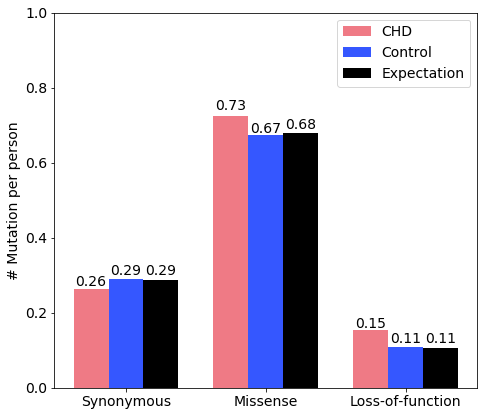

In [749]:
labels = ['Synonymous', 'Missense', 'Loss-of-function']
chd_rate = np.array([1011, 2781, 586]) / 3835
control_rate = np.array([625, 1459, 238]) / 2165
expected_rate = np.array([0.1430312559818024,0.3396175777975223,0.05366858450284304]) * 2

plt.rcParams.update({'font.size': 14})
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(7,6))
rects1 = ax.bar(x - width, chd_rate, width, label='CHD', color = "#ef7a85")
rects2 = ax.bar(x, control_rate, width, label='Control', color = "#3557ff")
rects3 = ax.bar(x + width, expected_rate, width, label='Expectation', color = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# Mutation per person')
#ax.set_title('Mutation type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

## Bootstrap enrichment analysis

This is used for thesis figure

In [14]:
# Total: 3835 probands - 2038 probands with > 0 missense mutation
missense_samples = np.unique(all_chd_scores['sample'])
print(len(all_chd_scores['sample']))
print(np.arange(0,10,1))
print(np.random.choice(10,10))


2896
[0 1 2 3 4 5 6 7 8 9]
[5 0 6 5 0 4 6 3 2 8]


In [113]:
# chd 
np.random.seed(1)
missense_samples = np.unique(all_chd_scores['sample'])
boot_num = np.empty((20,1000))
for i in range(1000):
    boot = np.random.choice(3835,3835)
    counts = [0] * 20
    for j in boot:
        if j < len(missense_samples):
            #print(missense_samples[j])
            scores = all_chd_scores[all_chd_scores['sample'] == missense_samples[j]]['PrimateAI_rankscore']
            for s in scores:
                if s != None:
                    for k in range(20):
                        if s >= k / 20.0 and s < (k+1) / 20.0:
                            counts[k] += 1
    
    for k in range(20):
        boot_num[k][i] = counts[k]

In [114]:
#control
np.random.seed(100)
missense_samples_ctrl = np.unique(all_chd_control_scores['sample'])
boot_num_control = np.empty((20,1000))
for i in range(1000):
    boot = np.random.choice(2179,2179)
    counts = [0] * 20
    for j in boot:
        if j < len(missense_samples_ctrl):
            #print(missense_samples[j])
            scores = all_chd_control_scores[all_chd_control_scores['sample'] == missense_samples_ctrl[j]]['PrimateAI_rankscore']
            for s in scores:
                if s != None:
                    for k in range(20):
                        if s >= k / 20.0 and s < (k+1) / 20.0:
                            counts[k] += 1
    
    for k in range(20):
        boot_num_control[k][i] = counts[k]

In [116]:
boot_num

array([[167., 185., 176., ..., 166., 161., 203.],
       [121., 109., 146., ..., 122., 144., 142.],
       [132., 132., 135., ..., 122., 147., 147.],
       ...,
       [156., 148., 155., ..., 172., 133., 134.],
       [186., 168., 207., ..., 178., 158., 173.],
       [200., 221., 173., ..., 180., 211., 194.]])

In [117]:
interval = np.empty((2,20))
interval_ctrl = np.empty((2,20))
for i in range(20):
    lo, hi = np.percentile(np.array(boot_num[i]) / (0.033918181658547986 * 3835),(2.5,97.5))
    interval[0][i] = lo
    interval[1][i] = hi

for i in range(20):
    lo, hi = np.percentile(np.array(boot_num_control[i]) / (0.033918181658547986 * 2179),(2.5,97.5))
    interval_ctrl[0][i] = lo
    interval_ctrl[1][i] = hi

In [145]:
#interval = np.empty((2,20))
#interval_ctrl = np.empty((2,20))
interval_2 = np.empty((2,3))
interval_ctrl_2 = np.empty((2,3))

interval_2[0][0], interval_2[1][0] = np.percentile(np.array(boot_num[18] + boot_num[19]) / (0.033918181658547986 * 3835 * 2),(2.5,97.5))
interval_ctrl_2[0][0], interval_ctrl_2[1][0] = np.percentile(np.array(boot_num_control[18] + boot_num_control[19]) / (0.033918181658547986 * 2179 * 2),(2.5,97.5))
interval_2[0][1], interval_2[1][1] = np.percentile(np.array(boot_num[15] + boot_num[16] + boot_num[17]) / (0.033918181658547986 * 3835 * 3),(2.5,97.5))
interval_ctrl_2[0][1], interval_ctrl_2[1][1] = np.percentile(np.array(boot_num_control[15] + boot_num_control[16] + boot_num_control[17]) / (0.033918181658547986 * 2179 * 3),(2.5,97.5))
interval_2[0][2], interval_2[1][2] = np.percentile(np.sum(boot_num[:15], axis=0) / (0.033918181658547986 * 3835 * 15),(2.5,97.5))
interval_ctrl_2[0][2], interval_ctrl_2[1][2] = np.percentile(np.sum(boot_num_control[:15], axis=0) / (0.033918181658547986 * 2179 * 15),(2.5,97.5))


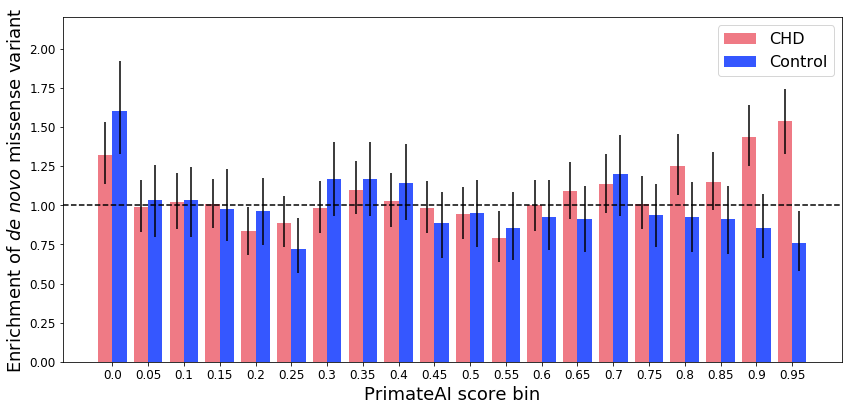

In [135]:
score_bin = []
chd_bin = []
control_bin = []
for i in range(0,20):
    score_bin.append((i) /20)
    chd_bin.append((sum(primateAI_chd > i/20) - sum(primateAI_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    #chd_bin.append((sum(MSVM_chd > i/20) - sum(MSVM_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    control_bin.append((sum(primateAI_control > i/20) - sum(primateAI_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    #control_bin.append((sum(MSVM_control > i/20) - sum(MSVM_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    
    #print(i/20, (sum(primateAI_chd > i/20) - sum(primateAI_chd > (i+1)/20) ) / (0.033918181658547986 *3835))
    #print(i/20, (sum(primateAI_chd > i/20)) / (0.033918181658547986 *3835 * (20-i)))
    #print(i/20, (sum(primateAI_control > i/20) - sum(primateAI_control > (i+1)/20) ) / (0.033964594379751946 *2165))
    
errors = [abs(interval[0] - chd_bin), interval[1] - chd_bin]
errors_ctrl = [abs(interval_ctrl[0] - control_bin), interval_ctrl[1] - control_bin]
    
#labels = ['Synonymous', 'Missense', 'Loss-of-function']
#chd_rate = np.array([1011, 2781, 586]) / 3835
#control_rate = np.array([625, 1459, 238]) / 2165
#expected_rate = np.array([0.1430312559818024,0.3396175777975223,0.05366858450284304]) * 2

plt.rcParams.update({'font.size': 12})
x = np.arange(len(score_bin))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width / 2, chd_bin, width, label='CHD', yerr = errors, color = "#ef7a85")
#rects2 = ax.bar(x, control_rate, width, label='Control', color = "#3557ff")
rects3 = ax.bar(x + width / 2, control_bin, width, label='Control', yerr = errors_ctrl, color = "#3557ff")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enrichment of $\it{de}$ $\it{novo}$ missense variant', fontsize=18)
ax.set_xlabel('PrimateAI score bin', fontsize=18)
#ax.set_title('Mutation type')
ax.set_xticks(x)
ax.set_xticklabels(score_bin)
ax.set_ylim((0,2.2))
ax.legend(fontsize = 16)

ax.axhline(1, linestyle = '--', color = 'black')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height + 0.02),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

fig.tight_layout()

plt.savefig('Fig2C.pdf')

plt.show()

In [150]:
0.033918181658547986 * 40

1.3567272663419194

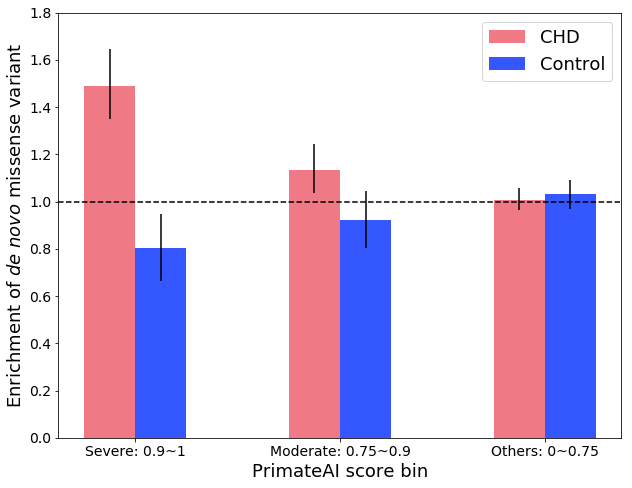

In [151]:
score_bin = ['Class 1', 'Class 2', 'others']
chd_bin = []
control_bin = []

chd_bin.append((sum(primateAI_chd > 0.9) ) / (0.033918181658547986 * 2 * 3835))
chd_bin.append((sum(primateAI_chd > 0.75) - sum(primateAI_chd > 0.9)) / (0.033918181658547986 * 3 * 3835))
chd_bin.append((sum(primateAI_chd > 0) - sum(primateAI_chd > 0.75 )) / (0.033918181658547986 * 15 * 3835))              
control_bin.append((sum(primateAI_control > 0.9) ) / (0.033918181658547986 * 2 * 2179))
control_bin.append((sum(primateAI_control > 0.75) - sum(primateAI_control > 0.9)) / (0.033918181658547986 * 3 * 2179))
control_bin.append((sum(primateAI_control > 0) - sum(primateAI_control > 0.75)) / (0.033918181658547986 * 15 * 2179))
              

errors = [abs(interval_2[0] - chd_bin), interval_2[1] - chd_bin]
errors_ctrl = [abs(interval_ctrl_2[0] - control_bin), interval_ctrl_2[1] - control_bin]

labels =  ['Severe: 0.9~1', 'Moderate: 0.75~0.9', 'Others: 0~0.75']

plt.rcParams.update({'font.size': 14})
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(9,7))
rects1 = ax.bar(x - width / 2, chd_bin, width, label='CHD', yerr = errors, color = "#ef7a85")
#rects2 = ax.bar(x, control_rate, width, label='Control', color = "#3557ff")
rects3 = ax.bar(x + width / 2, control_bin, width, label='Control', yerr = errors_ctrl, color = "#3557ff")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Enrichment of $\it{de}$ $\it{novo}$ missense variant', fontsize=18)
ax.set_xlabel('PrimateAI score bin', fontsize=18)
#ax.set_title('Mutation type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((0,1.8))
ax.axhline(1, linestyle = '--', color = 'black')

ax.legend(fontsize=18)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),4)
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

fig.tight_layout()

plt.savefig('FigS2.pdf')

plt.show()

## Unused

In [159]:
sum(primateAI_chd > 0.9)

387

In [308]:
mu_plof_dict = {}
with open('cryptic_splice_mutation_rate.protein_coding.1_22_X.txt', 'r') as mu_f:
    mu_reader = csv.reader(mu_f, delimiter = '\t')
    header = next(mu_reader)
    print(header)
    for row in mu_reader:
        gene = row[0]
        #if gene in gene_list:
        #    gene_list.remove(gene)
            #gene_list.append(gene)
        #if row[2] == "MT":
        #    continue
        #mu_syn = 10**float(row[8])
        
        #mu_mis = 10**float(row[4])

        if row[6] != "NA":
            mu_plof = 10**float(row[5])+10**float(row[6])+10**float(row[10])
        elif row[10] != "NA":
            mu_plof = 10**float(row[10])
        else:
            print(row)

        mu_plof_dict[]
        countA = misA_count_dict[gene] if gene in misA_count_dict else 0
        
        countB = misB_count_dict[gene] if gene in misB_count_dict else 0
        countpLoF = plof_count_dict[gene] if gene in plof_count_dict else 0
        countSyn = syn_count_dict[gene] if gene in syn_count_dict else 0
        #print(gene, mu_mis, countA, countB, mu_plof, countpLoF, mu_syn, countSyn)

print(gene_list)
        
for gene in gene_list:
    countA = misA_count_dict[gene] if gene in misA_count_dict else 0
    countB = misB_count_dict[gene] if gene in misB_count_dict else 0
    countpLoF = plof_count_dict[gene] if gene in plof_count_dict else 0
    countSyn = syn_count_dict[gene] if gene in syn_count_dict else 0
    print(gene, countA, countB, countpLoF, countSyn)           

['symbol', 'enst_transcript_id', 'chrom', 'length', 'missense_rate', 'nonsense_rate', 'splice_lof_rate', 'splice_region_rate', 'synonymous_rate', 'cryptic_splice_rate', 'frameshift_rate']
['NAXE', 'PCNX2', 'LRATD1', 'DARS1', 'RETREG2', 'NSD2', 'TENT5A', 'DOP1A', 'SYNE1', 'ITPRID1', 'TRMT9B', 'AJM1', 'DENND2B', 'C1R', 'MSLNL', 'MARF1', 'FCSK', 'ANGPTL8', 'GET3', 'BICRA', 'DEPP1', 'PLAAT4', 'CBY2', 'TEDC1', 'CCDC9B', 'MGA', 'SEPTIN12', 'MTSS2', 'TSPOAP1', 'HEXD', 'TLE5', 'SARS1', 'COQ8A', 'MACO1', 'MROH8', 'CFAP298', 'DDX17', 'MRTFA', 'PHETA2', 'CFAP65', 'GAREM2', 'PCARE', 'QARS1', 'GUCY1B1', 'ABRAXAS1', 'TBC1D9B', 'H2BC3', 'NRG1', 'PPDPFL', 'DNM1', 'HMCN2', 'CEMIP2', 'AOPEP']
NAXE 0 0 1 1
PCNX2 0 0 1 0
LRATD1 0 0 1 0
DARS1 0 0 1 0
RETREG2 0 0 1 0
NSD2 0 0 2 1
TENT5A 0 0 1 0
DOP1A 0 0 1 0
SYNE1 0 0 1 0
ITPRID1 0 0 1 0
TRMT9B 0 0 1 1
AJM1 0 0 1 1
DENND2B 0 0 1 1
C1R 0 0 1 0
MSLNL 0 0 3 0
MARF1 0 0 1 0
FCSK 0 0 1 0
ANGPTL8 0 0 1 0
GET3 0 0 1 0
BICRA 0 0 1 0
DEPP1 0 0 0 1
PLAAT4 0 0 0 1
CBY

In [295]:
#gene_list = []
with open('samocha2014.mu_rate.txt', 'r') as mu_f:
    mu_reader = csv.reader(mu_f, delimiter = '\t')
    header = next(mu_reader)
    print(header)
    for row in mu_reader:
        gene = row[0]
        if gene in gene_list:
            gene_list.remove(gene)
            #gene_list.append(gene)
        mu_syn = 10**float(row[3])
        mu_mis = 10**float(row[4])
        if row[6] != "NA":
            mu_plof = 10**float(row[5])+10**float(row[6])+10**float(row[7])
        else:
            mu_plof = 10**float(row[5])+10**float(row[7])
        countA = misA_count_dict[gene] if gene in misA_count_dict else 0
        countB = misB_count_dict[gene] if gene in misB_count_dict else 0
        countpLoF = plof_count_dict[gene] if gene in plof_count_dict else 0
        countSyn = syn_count_dict[gene] if gene in syn_count_dict else 0
        #print(gene, mu_mis, countA, countB, mu_plof, countpLoF, mu_syn, countSyn)

#print(gene_list)
        
for gene in gene_list:
    countA = misA_count_dict[gene] if gene in misA_count_dict else 0
    countB = misB_count_dict[gene] if gene in misB_count_dict else 0
    countpLoF = plof_count_dict[gene] if gene in plof_count_dict else 0
    countSyn = syn_count_dict[gene] if gene in syn_count_dict else 0
    #print(gene, countA, countB, countpLoF, countSyn)           

['gene', 'bp', 'all', 'syn', 'mis', 'non', 'splice_site', 'frameshift']
